In [231]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skew, spearmanr
import shap

from sklearn.model_selection import train_test_split, KFold, LeavePGroupsOut, LeaveOneGroupOut, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

seed = 69
np.random.seed(seed)
torch.manual_seed(seed)


In [232]:
root = '/home/ali/PycharmProjects/tihm/'
data = pd.read_csv(os.path.join(root, 'features-v2.csv'))

display(data)
display(data.columns.to_list())


acceleration    = data.filter(like='acceleration').columns.tolist()
heartrate       = data.filter(like='heartrate').filter(regex='^(?!.*sleep)').columns.tolist()
motion          = data.filter(like='motion').columns.tolist()
position        = data.filter(like='position').columns.tolist()
sleep           = data.filter(like='sleep').columns.tolist()
step            = data.filter(like='step').columns.tolist()



display(acceleration)
display(heartrate)
display(motion)
display(position)
display(sleep)
display(step)




,participant,timestamp,clinical-timestamp,sis-01,sis-02,sis-03,sis-04,sis-05,sis-06,sis,...,step-nonzero-mean,step-max,step-max-timestamp,sex,age,fracture-type,relationship,education,work,ethnicity
0,1,2022-03-31,2022-04-18,5.0,5.0,4.0,4.0,5.0,2.0,25.0,...,34.5833,106.0,13.0000,-1,74,-1,1,1,-1,1
1,1,2022-04-01,2022-04-18,5.0,5.0,4.0,4.0,5.0,2.0,25.0,...,63.8571,185.0,8.0000,-1,74,-1,1,1,-1,1
2,1,2022-04-02,2022-04-18,5.0,5.0,4.0,4.0,5.0,2.0,25.0,...,52.1866,161.5,14.3889,-1,74,-1,1,1,-1,1
3,1,2022-04-03,2022-04-18,5.0,5.0,4.0,4.0,5.0,2.0,25.0,...,106.0000,288.0,22.0000,-1,74,-1,1,1,-1,1
4,1,2022-04-04,2022-04-18,5.0,5.0,4.0,4.0,5.0,2.0,25.0,...,76.2222,176.0,11.0000,-1,74,-1,1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,10,2024-12-14,2024-12-18,3.0,5.0,3.0,2.0,3.0,2.0,18.0,...,34.7143,131.0,17.0000,1,77,3,1,-1,-1,-1
556,10,2024-12-15,2024-12-18,3.0,5.0,3.0,2.0,3.0,2.0,18.0,...,152.2000,916.0,14.0000,1,77,3,1,-1,-1,-1
557,10,2024-12-16,2024-12-18,3.0,5.0,3.0,2.0,3.0,2.0,18.0,...,84.0909,326.0,17.0000,1,77,3,1,-1,-1,-1
558,10,2024-12-17,2024-12-18,3.0,5.0,3.0,2.0,3.0,2.0,18.0,...,62.6667,192.0,11.0000,1,77,3,1,-1,-1,-1


['participant',
 'timestamp',
 'clinical-timestamp',
 'sis-01',
 'sis-02',
 'sis-03',
 'sis-04',
 'sis-05',
 'sis-06',
 'sis',
 'ohs-01',
 'ohs-02',
 'ohs-03',
 'ohs-04',
 'ohs-05',
 'ohs-06',
 'ohs-07',
 'ohs-08',
 'ohs-09',
 'ohs-10',
 'ohs-11',
 'ohs-12',
 'ohs',
 'oks-01',
 'oks-02',
 'oks-03',
 'oks-04',
 'oks-05',
 'oks-06',
 'oks-07',
 'oks-08',
 'oks-09',
 'oks-10',
 'oks-11',
 'oks-12',
 'oks',
 'tug',
 'chairstand',
 'acceleration-count',
 'acceleration-mean',
 'acceleration-std',
 'acceleration-sum',
 'acceleration-entropy',
 'acceleration-kurtosis',
 'acceleration-skew',
 'acceleration-coefficient-of-variation',
 'acceleration-minutes-with-data',
 'acceleration-hours-with-data',
 'acceleration-movement-events-00to06',
 'acceleration-movement-events-06to12',
 'acceleration-movement-events-12to18',
 'acceleration-movement-events-18to24',
 'acceleration-movement-events-24h',
 'acceleration-intradaily-variability',
 'heartrate-count',
 'heartrate-min',
 'heartrate-max',
 'heart

['acceleration-count',
 'acceleration-mean',
 'acceleration-std',
 'acceleration-sum',
 'acceleration-entropy',
 'acceleration-kurtosis',
 'acceleration-skew',
 'acceleration-coefficient-of-variation',
 'acceleration-minutes-with-data',
 'acceleration-hours-with-data',
 'acceleration-movement-events-00to06',
 'acceleration-movement-events-06to12',
 'acceleration-movement-events-12to18',
 'acceleration-movement-events-18to24',
 'acceleration-movement-events-24h',
 'acceleration-intradaily-variability']

['heartrate-count',
 'heartrate-min',
 'heartrate-max',
 'heartrate-mean',
 'heartrate-std',
 'heartrate-hours-with-data']

['motion-count',
 'motion-ratio',
 'motion-nonzero-mean',
 'motion-max',
 'motion-max-timestamp']

['position-count',
 'position-mean',
 'position-max',
 'position-duration',
 'position-distance-travelled']

['sleep-total-sleep-duration',
 'sleep-deep-sleep-duration',
 'sleep-light-sleep-duration',
 'sleep-rem-sleep-duration',
 'sleep-snoring-duration',
 'sleep-duration-to-sleep',
 'sleep-duration-to-wakeup',
 'sleep-wakeup-count',
 'sleep-heartrate-mean',
 'sleep-heartrate-min',
 'sleep-heartrate-max']

['step-count',
 'step-ratio',
 'step-nonzero-mean',
 'step-max',
 'step-max-timestamp']

In [233]:
modalities = acceleration + heartrate + motion + position + sleep + step
sensor = data[modalities]

sis = data['sis']
participant = data['participant']

x = np.array(sensor)
y = np.array(sis)
p = np.array(participant)

display(x.shape, y.shape, p.shape)

(560, 48)

(560,)

(560,)

Fold 1: train=448 test=112
Fold 2: train=448 test=112
Fold 3: train=448 test=112
Fold 4: train=448 test=112
Fold 5: train=448 test=112


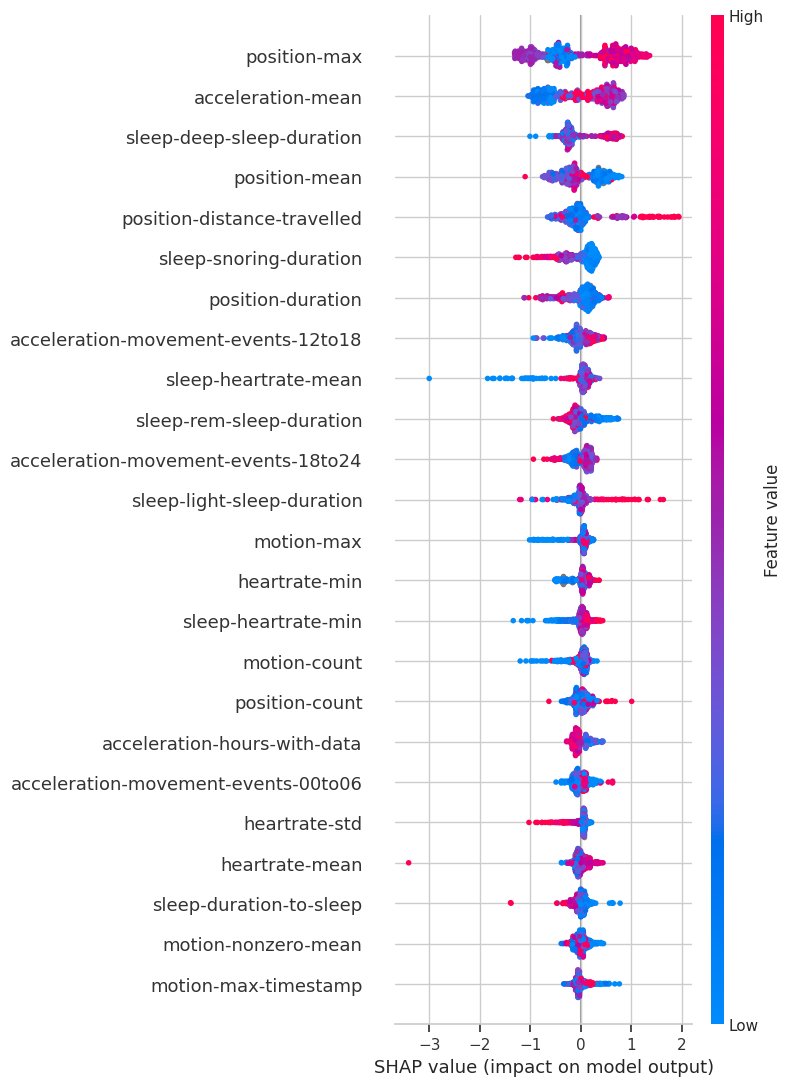

In [234]:
Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])
SHAP = []
X_TEST = []

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):
    
    print(f"Fold {fold}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )

    model.fit(x_train, y_train, eval_set=(x_train, y_train), use_best_model=True, early_stopping_rounds=100)
    y_preds = model.predict(x_test)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)

    SHAP.append(shap_values)
    X_TEST.append(x_test)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)


shap_df = pd.DataFrame({
    'feature': modalities,
    'mean_abs_shap': np.abs(np.vstack(SHAP)).mean(axis=0).round(4)
}).sort_values(by='mean_abs_shap', ascending=False)
# display(shap_df)
shap.summary_plot(np.vstack(SHAP), pd.DataFrame(np.vstack(X_TEST), columns=modalities), max_display=24)

# Select the first num_features features based on SHAP importance
num_features = 16
x = np.array(data[shap_df['feature'].iloc[:16]])

Fold 1: train=504 test=56
Fold 2: train=504 test=56
Fold 3: train=504 test=56
Fold 4: train=504 test=56
Fold 5: train=504 test=56
Fold 6: train=504 test=56
Fold 7: train=504 test=56
Fold 8: train=504 test=56
Fold 9: train=504 test=56
Fold 10: train=504 test=56


mae,mse,r2_score,correlation
1.2069,2.9798,0.7196,0.8761


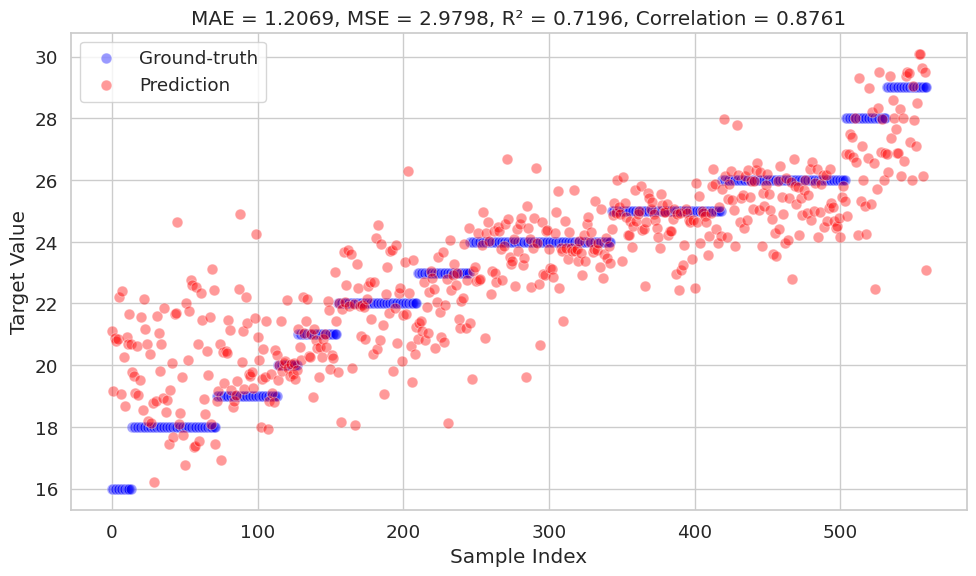

In [235]:
# 10-FOLD

Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])

cv = KFold(n_splits=10, shuffle=True, random_state=seed)

for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

    print(f"Fold {fold}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)

    # ----- CatBoost
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )
    
    model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, early_stopping_rounds=100)
    y_preds = model.predict(x_test)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)

indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PREDS = Y_PREDS[indx]

mae = mean_absolute_error(Y_TRUES, Y_PREDS)
mse = mean_squared_error(Y_TRUES, Y_PREDS)
r2 = r2_score(Y_TRUES, Y_PREDS)
corr, _ = spearmanr(Y_TRUES, Y_PREDS)

results = {
    'mae': f"{mae:.4f}",
    'mse': f"{mse:.4f}",
    'r2_score': f"{r2:.4f}",
    'correlation': f"{corr:.4f}"
}

results = pd.DataFrame([results])
display(results.style.hide(axis='index'))

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(Y_TRUES)), y=Y_TRUES, label='Ground-truth', color='blue', alpha=0.4, s=60)
sns.scatterplot(x=range(len(Y_PREDS)), y=Y_PREDS, label='Prediction', color='red', alpha=0.4, s=60)

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f"MAE = {mae:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}, Correlation = {corr:.4f}")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Participant 1: train=504 test=56
Participant 2: train=504 test=56
Participant 3: train=504 test=56
Participant 4: train=504 test=56
Participant 5: train=504 test=56
Participant 6: train=504 test=56
Participant 7: train=504 test=56
Participant 8: train=504 test=56
Participant 9: train=504 test=56
Participant 10: train=504 test=56


mae,mse,r2_score,correlation
2.4270,9.6831,0.0889,0.2239


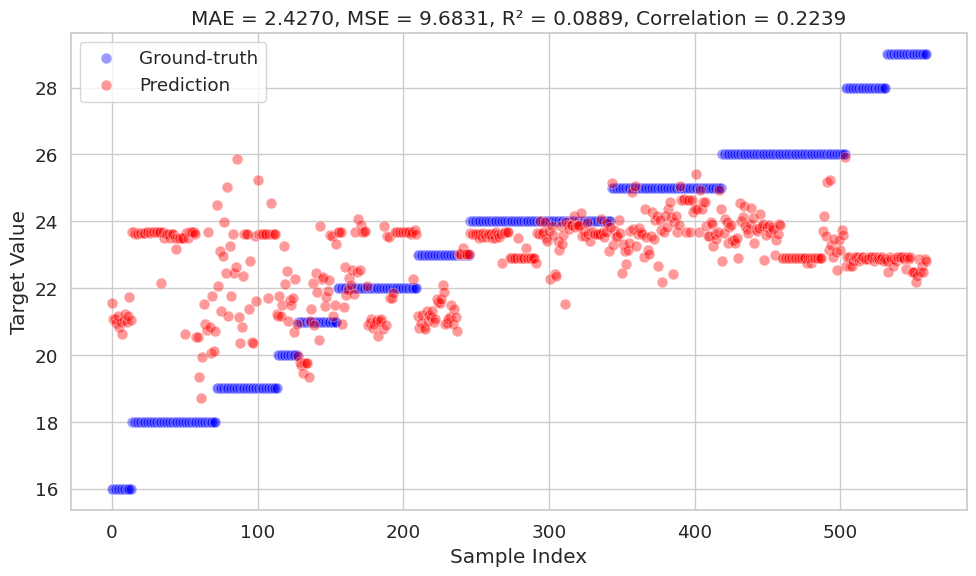

In [236]:
# LOPO

Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])

cv = LeaveOneGroupOut()

for fold, (train_idx, test_idx) in enumerate(cv.split(x, y, groups=p), start=1):

    participant = np.unique(p[test_idx])[0]

    print(f"Participant {participant}: train={len(train_idx)} test={len(test_idx)}")


    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)
    
    
    # ----- CatBoost
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )
    
    model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, early_stopping_rounds=100)

    y_preds = model.predict(x_test)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)

indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PREDS = Y_PREDS[indx]

mae = mean_absolute_error(Y_TRUES, Y_PREDS)
mse = mean_squared_error(Y_TRUES, Y_PREDS)
r2 = r2_score(Y_TRUES, Y_PREDS)
corr, _ = spearmanr(Y_TRUES, Y_PREDS)

results = {
    'mae': f"{mae:.4f}",
    'mse': f"{mse:.4f}",
    'r2_score': f"{r2:.4f}",
    'correlation': f"{corr:.4f}"
}

results = pd.DataFrame([results])
display(results.style.hide(axis='index'))

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(Y_TRUES)), y=Y_TRUES, label='Ground-truth', color='blue', alpha=0.4, s=60)
sns.scatterplot(x=range(len(Y_PREDS)), y=Y_PREDS, label='Prediction', color='red', alpha=0.4, s=60)

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f"MAE = {mae:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}, Correlation = {corr:.4f}")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Sample 0: train=559 test=1
Sample 1: train=559 test=1
Sample 2: train=559 test=1
Sample 3: train=559 test=1
Sample 4: train=559 test=1
Sample 5: train=559 test=1
Sample 6: train=559 test=1
Sample 7: train=559 test=1
Sample 8: train=559 test=1
Sample 9: train=559 test=1
Sample 10: train=559 test=1
Sample 11: train=559 test=1
Sample 12: train=559 test=1
Sample 13: train=559 test=1
Sample 14: train=559 test=1
Sample 15: train=559 test=1
Sample 16: train=559 test=1
Sample 17: train=559 test=1
Sample 18: train=559 test=1
Sample 19: train=559 test=1
Sample 20: train=559 test=1
Sample 21: train=559 test=1
Sample 22: train=559 test=1
Sample 23: train=559 test=1
Sample 24: train=559 test=1
Sample 25: train=559 test=1
Sample 26: train=559 test=1
Sample 27: train=559 test=1
Sample 28: train=559 test=1
Sample 29: train=559 test=1
Sample 30: train=559 test=1
Sample 31: train=559 test=1
Sample 32: train=559 test=1
Sample 33: train=559 test=1
Sample 34: train=559 test=1
Sample 35: train=559 test=1
Sa

mae,mse,r2_score,correlation
0.7127,1.8041,0.8302,0.9495


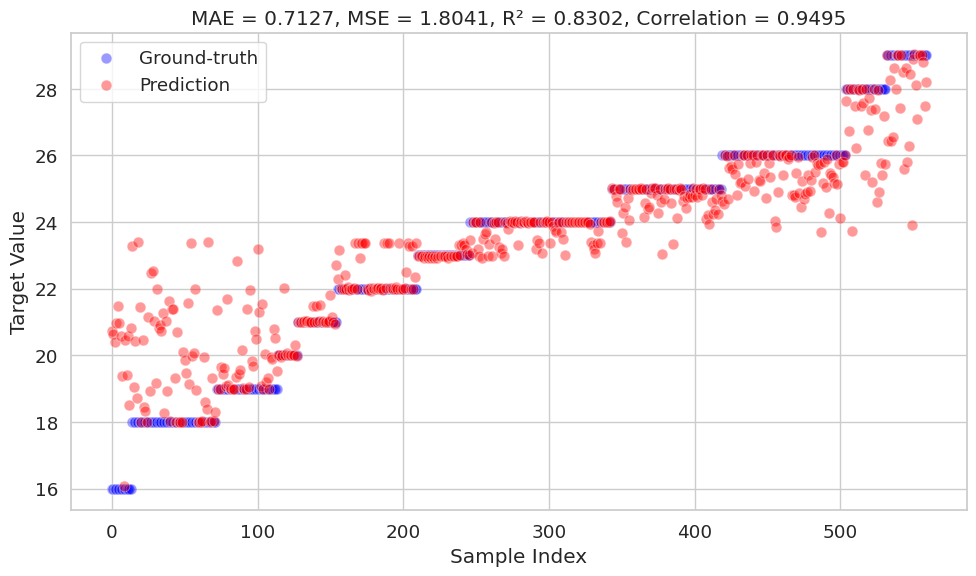

In [237]:
# LOSO

Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])

cv = LeaveOneOut()

for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

    print(f"Sample {test_idx[0]}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)

    # ----- CatBoost
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )

    model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, early_stopping_rounds=100)
    y_preds = model.predict(x_test)


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'objective': 'regression',
    #     'metric': 'rmse',
    #     'num_leaves': 31,
    #     'learning_rate': 0.05,
    #     'n_estimators': 100
    # }
    # model = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_preds = model.predict(x_test, num_iteration=model.best_iteration)


    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)

indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PREDS = Y_PREDS[indx]

mae = mean_absolute_error(Y_TRUES, Y_PREDS)
mse = mean_squared_error(Y_TRUES, Y_PREDS)
r2 = r2_score(Y_TRUES, Y_PREDS)
corr, _ = spearmanr(Y_TRUES, Y_PREDS)

results = {
    'mae': f"{mae:.4f}",
    'mse': f"{mse:.4f}",
    'r2_score': f"{r2:.4f}",
    'correlation': f"{corr:.4f}"
}

results = pd.DataFrame([results])
display(results.style.hide(axis='index'))

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(Y_TRUES)), y=Y_TRUES, label='Ground-truth', color='blue', alpha=0.4, s=60)
sns.scatterplot(x=range(len(Y_PREDS)), y=Y_PREDS, label='Prediction', color='red', alpha=0.4, s=60)

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f"MAE = {mae:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}, Correlation = {corr:.4f}")
plt.legend(loc='best')
plt.tight_layout()
plt.show()
